<a href="https://colab.research.google.com/github/mridul-eecs/skin-cancer-classification/blob/master/SkinCancerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bussiness Problem


### Description

Problem Statement: The project solves skin cancer classificaion by looking at the images. The skin cancer will be classified into 7 classes as follows.

1. Bowen's disease (akiec),
2. basal cell carcinoma (bcc),
3. benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), 
4. dermatofibroma (df), 
5. melanoma (mel), 
6. melanocytic nevi (nv) and 
7. vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

Data Source: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/version/2

Algorithmic objectives and constraints:

1. Low latency not required
2. Interpretability is required
3. Errors are very costly
4. Probability of a data-point belonging to each class is needed

Performance Metrics:

1. Multi class log loss
2. Accuracy
3. Multi class Confusion matrix

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir -p ~/.kaggle
!cp drive/My\ Drive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

kaggle.json
100% 5.20G/5.20G [01:46<00:00, 86.1MB/s]
100% 5.20G/5.20G [01:46<00:00, 52.7MB/s]


In [0]:
!unzip -qq skin-cancer-mnist-ham10000.zip -d data

In [0]:
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

ISIC_0029940.jpg


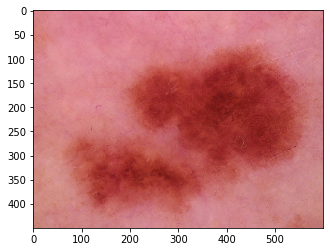

In [0]:
contents= os.listdir('data/ham10000_images_part_2/')
print(contents[0])
img= Image.open(('data/ham10000_images_part_2/' + contents[0]))
plt.imshow(img)

In [0]:
import pandas as pd
df= pd.read_csv('data/HAM10000_metadata.csv')
df.head(2)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp


In [0]:
# matching images with their classes
# number of classes
# stands for the following
print(df['dx'].unique())
print("Bowen's disease (akiec),\nbasal cell carcinoma (bcc),\n\
benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), \n\
dermatofibroma (df), \nmelanoma (mel), \nmelanocytic nevi (nv) and \n\
vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).")

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Bowen's disease (akiec),
basal cell carcinoma (bcc),
benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), 
dermatofibroma (df), 
melanoma (mel), 
melanocytic nevi (nv) and 
vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).


(450, 600, 3)


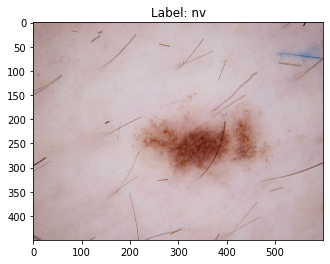

In [0]:
# converting dataset into pytorch Dataset datastructure
from torchvision.transforms import transforms, ToTensor, Normalize
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from scipy import ndimage
import torch

class skinMNIST(Dataset):
  def __init__(self, dataframe, transforms= None):
    super().__init__()
    self.df= dataframe
    self.transform= transforms

  def __len__(self):
    return(self.df.shape[0])

  def labels(self):
    labels= self.df['dx'].unique()
    labels= sorted(labels)
    return 
    
  def description(self):
      return self.df['dx'].value_counts()

  def __getitem__(self, idx):
    labels= dict(zip(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], range(7)))
    row = self.df.iloc[idx]
    image = row['image_id'] 
    # label_one_hot= np.zeros(7).astype(int)
    # label_one_hot[labels[row['dx']]] = 1
    try:
      image= Image.open(('data/data/ham10000_images_part_2/' + image + '.jpg'))
    except:
      image= Image.open(('data/data/ham10000_images_part_1/' + image + '.jpg'))

    if self.transform:
      image= self.transform(image)
    label =int(labels[row['dx']])
    return image, torch.tensor(label)

  def visulizeitem(self, idx):
    row = self.df.iloc[idx]
    image = row['image_id']
    label = row['dx'] 
    try:
      image= Image.open(('data/data/ham10000_images_part_2/' + image + '.jpg'))
    except:
      image= Image.open(('data/data/ham10000_images_part_1/' + image + '.jpg'))

    print(np.shape(image))
    fig= plt.figure()
    plt.title('Label: {}'.format(label))
    plt.imshow(image)
    

tf= transforms.Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
ds= skinMNIST(df, tf)
ds.visulizeitem(9045)

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


<BarContainer object of 7 artists>

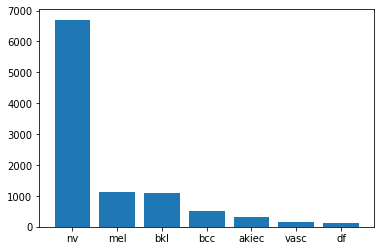

In [0]:
# Distribution of data
desc= ds.description()
print(desc)
desc= dict(desc)
plt.bar(desc.keys(), desc.values())

In [0]:
# dataset seems to be highly imbalanced
# performing data balancing technique
# There are several techniques like undersampling, oversampling, partial augmentation, class weight balancing
# We are going for the custom partial augmentation here.
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm_notebook as tqdm

gen= ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, 
                        shear_range=0.15, zoom_range= 0.1, channel_shift_range= 10, horizontal_flip= True)

for key in desc.keys():
  print(key, desc[key])
  ratio= int(desc['nv']/ desc[key])
  print('ratio to nv: ', ratio)
  print('We need around', ratio, ' augmentation per image to change ratio to 1')
  all_images= df[df['dx'] == key]['image_id'].values
  if(key == 'nv'):
    continue
  printonce= True
  # iterate over all images augment them, save them and insert them in our metadata frame
  for image_ in tqdm(all_images):
    if(len(df[df['dx'] == key]) > len(df[df['dx'] == 'nv'])):
      if printonce:
        print(key, 'datapoints = ', len(df[df['dx'] == key]), 'reached above nv skipping more augmentations..')
        printonce= False
      continue
    try:
      basedir= 'data/ham10000_images_part_1/'
      image_path=  basedir + image_ + '.jpg'
      image= load_img(image_path)
    except:
      basedir= 'data/ham10000_images_part_2/'
      image_path= basedir + image_ + '.jpg'
      image= load_img(image_path)

    image= np.expand_dims(img_to_array(image), axis= 0)
    generated= gen.flow(image)
    row= df[df['image_id'] == image_]
    dict_for_df= {
        'lesion_id':row.lesion_id.values[0], 'image_id':row.image_id.values[0], 
        'dx':row.dx.values[0], 'dx_type':row.dx_type.values[0] ,
        'age':row.age.values[0], 'sex':row.sex.values[0], 'localization':row.localization.values[0] 
    }
    for i in range(int(ratio)):
      aug_image= next(generated).astype(np.uint8)
      # save this image with an underscore
      # add this to metadata dataframe
      image_name= dict_for_df['image_id'] + '_' + str(i)
      dict_for_df['image_id'] = image_name
      df = df.append(dict_for_df, ignore_index=True)
      plt.imsave(basedir + image_name + '.jpg', aug_image[0])


Using TensorFlow backend.


nv 6705
ratio to nv:  1
We need around 1  augmentation per image to change ratio to 1
mel 1113
ratio to nv:  6
We need around 6  augmentation per image to change ratio to 1


mel datapoints =  6711 reached above nv skipping more augmentations..

bkl 1099
ratio to nv:  6
We need around 6  augmentation per image to change ratio to 1


bkl datapoints =  6709 reached above nv skipping more augmentations..

bcc 514
ratio to nv:  13
We need around 13  augmentation per image to change ratio to 1


bcc datapoints =  6715 reached above nv skipping more augmentations..

akiec 327
ratio to nv:  20
We need around 20  augmentation per image to change ratio to 1


akiec datapoints =  6707 reached above nv skipping more augmentations..

vasc 142
ratio to nv:  47
We need around 47  augmentation per image to change ratio to 1


vasc datapoints =  6722 reached above nv skipping more augmentations..

df 115
ratio to nv:  58
We need around 58  augmentation per image to change ratio to 1


df datapoints =  6727 reached above nv skipping more augmentations..



df       6727
vasc     6722
bcc      6715
mel      6711
bkl      6709
akiec    6707
nv       6705
Name: dx, dtype: int64


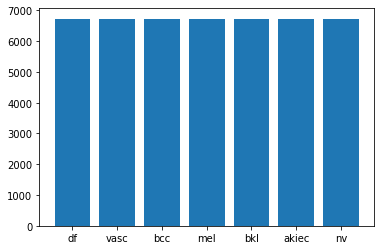

In [0]:
ds2= skinMNIST(df, tf)
desc= ds2.description()
print(desc)
desc= dict(desc)
plt.bar(desc.keys(), desc.values())
df.to_csv('drive/My Drive/skincancerdata/dataframe.csv')

In [0]:
# Now this looks like somewhat balanced dataset, lets proceed with the  train test split

In [0]:
# 80% Train 20% Test Spilt
train_size = int(0.8 * len(ds2))
test_size = len(ds2) - train_size
trainset, testset= torch.utils.data.random_split(ds2, [train_size, test_size])
print(len(trainset), len(testset))

37596 9400


In [0]:
!zip -r -qq drive/My\ Drive/skincancerdata/ham10000_images_part_1.zip data/ham10000_images_part_1
!zip -r -qq drive/My\ Drive/skincancerdata/ham10000_images_part_2.zip data/ham10000_images_part_2

In [0]:
!unzip -qq drive/My\ Drive/skincancerdata/ham10000_images_part_1.zip -d data
!unzip -qq drive/My\ Drive/skincancerdata/ham10000_images_part_2.zip -d data

In [0]:
import pandas as pd
df= pd.read_csv('drive/My Drive/skincancerdata/dataframe.csv')

In [0]:
from torchvision import models
import torch.nn as nn

net = models.resnet18(pretrained=True)

net.fc = nn.Sequential(
                      nn.Linear(512, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 7),                   
                      nn.LogSoftmax(dim=1)
                      )

net = net.cuda()
net

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 281MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
train_loader = DataLoader(trainset, batch_size= 32, shuffle= True)
test_loader = DataLoader(testset, batch_size= 32, shuffle= True)
data, label= next(iter(train_loader))
# print(label)
op= net(data.cuda())
print(op)
print(np.shape(op))
# print(data)

tensor([[-2.0110, -1.7853, -1.8645, -2.0156, -1.9466, -2.2923, -1.7935],
        [-2.4512, -1.7186, -2.0289, -1.8216, -1.8372, -2.1755, -1.7812],
        [-1.8377, -2.0776, -2.1348, -1.7345, -2.3630, -1.6919, -1.9482],
        [-1.7732, -1.8327, -2.0860, -1.9750, -1.6885, -2.2661, -2.1305],
        [-1.7538, -2.0157, -2.1178, -1.7321, -1.9591, -2.0557, -2.0600],
        [-1.9943, -2.2218, -1.9015, -1.5485, -1.9304, -1.8833, -2.3394],
        [-2.1817, -2.0187, -1.9507, -1.8222, -2.0062, -1.9108, -1.7836],
        [-2.4929, -1.8031, -2.0191, -1.5950, -1.6632, -2.2360, -2.1166],
        [-2.1206, -1.9752, -2.1066, -1.8138, -1.8630, -1.7423, -2.0691],
        [-1.9400, -2.3800, -1.8332, -1.7370, -1.9302, -1.7641, -2.1952],
        [-1.8002, -2.1053, -2.2203, -2.0617, -1.6045, -2.1184, -1.8584],
        [-2.4433, -2.0035, -2.2716, -1.5271, -1.8791, -1.9698, -1.7973],
        [-2.3346, -2.0381, -1.8353, -1.9023, -1.7607, -1.8147, -2.0458],
        [-2.3811, -1.9247, -2.2719, -1.5018, -2.034

In [0]:
from torch.utils.data import DataLoader
import torch.optim as optim

criterion= nn.CrossEntropyLoss()

val_losses= []
def validation():
  vloss= 0.0
  print('validating..')
  with torch.no_grad():
    net.eval()
    total_count, true_count, i= 0, 0, 0
    for test_data, test_label in (test_loader):
      i+=1
      output= net(test_data.cuda()) 
      vloss+= criterion(output, test_label.cuda())
      avg_val_loss= vloss/i
      for op, test in zip(output, test_label.cuda()):
        total_count+= 1
        if(torch.argmax(op) == test):
          true_count+= 1
    correct= (true_count * 100)/ total_count
    val_losses.append(avg_val_loss)
    return avg_val_loss, correct




# Training starts here  

optimizer = optim.Adam(net.parameters(), lr= 0.0001, weight_decay=1e-5)
patience = 16
train_losses= []
val_losses= []
patience= 3
for epoch in range(1, 20):
  print('training..')
  net.train()
  totalloss= 0
  i= 0
  for train_data, train_label in (train_loader):
    optimizer.zero_grad()
    output= net(train_data.cuda())
    loss= criterion(output, train_label.cuda())
    totalloss+= loss
    i+=1
    avgloss= totalloss/i
    loss.backward()
    optimizer.step()
  train_losses.append(avgloss)  
  valloss, acc= validation()
  print('training loss in epoch {} is {}, validation loss is {} correctly classified= {} %'.format(epoch, avgloss, valloss, acc))
  try:
    if(val_losses[-1] >= val_losses[-2]):
      print('Early stopping... saving checkpoint..')
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
      torch.save(net.state_dict(), 'checkpoint_{}_{}.pt'.format(epoch, acc))
      patience-=1
      if patience == 0:
        break
  except:
    pass


training..
validating..
training loss in epoch 1 is 0.07898491621017456, validation loss is 0.13209940493106842 correctly classified= 95.86170212765957 %
training..
validating..
training loss in epoch 2 is 0.055795878171920776, validation loss is 0.08103486895561218 correctly classified= 97.13829787234043 %
training..
validating..
training loss in epoch 3 is 0.04809686169028282, validation loss is 0.07846726477146149 correctly classified= 97.27659574468085 %
training..
validating..
training loss in epoch 4 is 0.04189615324139595, validation loss is 0.06905442476272583 correctly classified= 97.70212765957447 %
training..
validating..
training loss in epoch 5 is 0.03484661132097244, validation loss is 0.16723449528217316 correctly classified= 95.02127659574468 %
Early stopping... saving checkpoint..
training..
validating..
training loss in epoch 6 is 0.03438245505094528, validation loss is 0.09963449835777283 correctly classified= 96.87234042553192 %
training..
validating..
training loss

In [0]:
!cp checkpoint_11_97.95744680851064.pt drive/My\ Drive/skincancerdata/

In [0]:
with torch.no_grad():
  net.eval()
  data, label= next(iter(test_loader))
  op= net(data.cuda())[0]
  print(op)# 
  print(torch.argmax(op))
  print(label[0])


tensor([-1.7772e+01, -1.7203e+01, -1.5430e+01, -1.7615e+01, -3.8147e-06,
        -1.2622e+01, -1.9066e+01], device='cuda:0')
tensor(4, device='cuda:0')
tensor(4)


In [0]:
# Evaluating and testing our model on CPU instead of GPU
# lets pick a random image from the dataframe and its label
from random import randint
random_variable= randint(1, 10000)
imageid= df.iloc[random_variable].image_id
cancertype= df.iloc[random_variable].dx
try:
  image= Image.open(('data/ham10000_images_part_2/' + imageid + '.jpg'))
except:
  image= Image.open(('data/ham10000_images_part_1/' + imageid + '.jpg'))

# convert jpeg image into 3 dimentional tensor
trans =transforms.ToTensor()
# convert image into 4 dimentional tensor required to feed into the network
image= trans(image).unsqueeze(0)
inversedict= dict(zip(range(7), ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']))
with torch.no_grad():
  net.eval().cpu()
  op= net(image)
  op= op.argmax().item()
  print('image_name:', imageid)
  print('real:', cancertype)
  print('predicted:', inversedict[op])


image_name: ISIC_0027821
real: nv
predicted: nv


In [0]:
#plotting the confusion matrix
def get_all_preds(model):
  # an instance of the dataset
  ds= skinMNIST(df, tf)
  all_batches= DataLoader(ds, batch_size= 32, shuffle= False)
  cfmat= []
  with torch.no_grad():
    model.eval().cuda()
    for batches, labels in tqdm(all_batches):
      op= model(batches.cuda())
      op= op.argmax(dim=1)
      stack= torch.stack((op, labels.cuda()), dim=1)
      cfmat+= stack.tolist()
          
  return cfmat

# cf= get_all_preds(net)

NameError: ignored

In [0]:
import seaborn as sns
print(np.shape(cf))
cfmat= np.zeros((7,7), dtype= int)
for p in cf:
    tl, pl = p
    cfmat[tl, pl] = cfmat[tl, pl] + 1
print('confusion matrix:\n',cfmat)

(46996, 2)
confusion matrix:
 [[6688    0    7    0    0    1    0]
 [  18 6711   11    0    4    4    0]
 [   1    0 6615    0    5    9    0]
 [   0    1    0 6726    0    0    0]
 [   0    0   29    0 6628   34    0]
 [   0    3   47    1   69 6657    1]
 [   0    0    0    0    5    0 6721]]


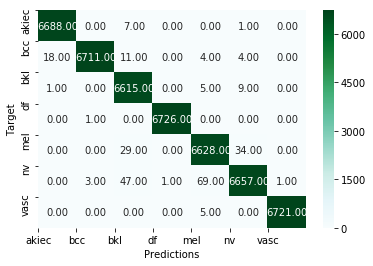

In [0]:
import seaborn as sns
inversedict= dict(zip(range(7), ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']))

res = sns.heatmap(cfmat, annot=True, fmt='.2f',cmap=plt.cm.BuGn)
plt.ylabel('Target')
plt.xlabel('Predictions')
plt.xticks(range(7), [inversedict[i] for i in range(7)])
plt.yticks(range(7), [inversedict[i] for i in range(7)])
plt.show()

In [0]:
# it can be observed that the 'nv' class is misclassifed into mel and bkl classes, so we should be careful with it.
 

In [0]:
# deploy the model
# create the net

from torchvision import models
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm

net2 = models.resnet18(pretrained=True)

net2.fc = nn.Sequential(
                      nn.Linear(512, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 7),                   
                      nn.LogSoftmax(dim=1)
                      )

net2 = net2.cuda()
net2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
checkpoint = torch.load('drive/My Drive/skincancerdata/checkpoint_11_97.95744680851064.pt')
net2.load_state_dict(checkpoint)
# testing net2
cf2= get_all_preds(net2)
cfmat= np.zeros((7,7), dtype= int)
for p in cf2:
    tl, pl = p
    cfmat[tl, pl] = cfmat[tl, pl] + 1
print('confusion matrix:\n',cfmat)



confusion matrix:
 [[6688    0    7    0    0    1    0]
 [  18 6711   11    0    4    4    0]
 [   1    0 6615    0    5    9    0]
 [   0    1    0 6726    0    0    0]
 [   0    0   29    0 6628   34    0]
 [   0    3   47    1   69 6657    1]
 [   0    0    0    0    5    0 6721]]


In [0]:
cfmat[0][5]

1

predicted: nv


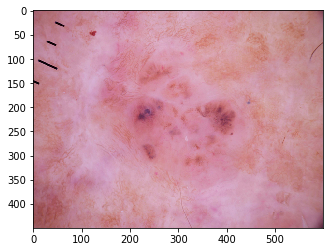

In [0]:
from torchvision import models
import torch.nn as nn
from PIL import Image
from torchvision.transforms import transforms
import torch
import matplotlib.pyplot as plt


net = models.resnet18(pretrained=False)
net.fc = nn.Sequential(
                      nn.Linear(512, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 7),                   
                      nn.LogSoftmax(dim=1)
                      )
IMAGEPATH= 'data/HAM10000_images_part_1/ISIC_0024472.jpg'
checkpoint = torch.load('drive/My Drive/skincancerdata/checkpoint_11_97.95744680851064.pt')
net.load_state_dict(checkpoint)
image= Image.open(IMAGEPATH)
trans =transforms.ToTensor()
image_tensor= trans(image).unsqueeze(0)
inversedict= dict(zip(range(7), ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']))
with torch.no_grad():
  net.eval().cpu()
  op= net(image_tensor)
  op= op.argmax().item()
  plt.imshow(image)
  print('predicted:', inversedict[op])